# Trần Nguyên Trung - 19127607

- import library

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

- Đọc file và phân tích dữ liệu

In [2]:
sample_submission="./plant-pathology-2020-fgvc7/sample_submission.csv"
submission = pd.read_csv(sample_submission)
train = pd.read_csv('./plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('./plant-pathology-2020-fgvc7/test.csv')
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [3]:
print('Train: ', train_data.shape)
print('Test: ', test_data.shape)

Train:  (1821, 5)
Test:  (1821, 1)


- Lưu các hình ảnh test và train

In [4]:

img_folder_path = './plant-pathology-2020-fgvc7/images'
a = train_data['image_id']
train_img = [i for i in a]
a = test_data['image_id']
test_img = [i for i in a]


- Cấu hình các cột bệnh, epochs, size image và size batch để sử dụng ImageDatagenerator

In [5]:
column_names=["healthy","multiple_diseases","rust","scab"]
epochs = 8
img_height = 180
img_width = 180
batch_size = 64

- Dữ liệu train

In [6]:
healthy = len(train_data[train_data['healthy'] == 1])
mul_disease = len(train_data[train_data['multiple_diseases'] == 1])
rust = len(train_data[train_data['rust'] == 1])
scab = len(train_data[train_data['scab'] == 1])
print('Healthy: ', healthy)
print('Multiple diseases: ', mul_disease)
print('Rust: ', rust)
print('Scab: ', scab)

Healthy:  516
Multiple diseases:  91
Rust:  622
Scab:  592


- Thêm đuôi jpg cho image_id

In [7]:
for i in tqdm(range(train.shape[0])):
    img=(train['image_id'])
add = img.astype(str)+".jpg"
train['image_id'] = add 

for i in tqdm(range(test.shape[0])):
    img=(test['image_id'][:])
add = img.astype(str)+".jpg"
test['image_id'] = add

100%|███████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 27166.77it/s]


- ImageDatagenerator giảm việc load data. Lấy các validated image

In [8]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      zca_whitening=False,
      zca_epsilon=1e-06,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=(0.1,1.0),
      channel_shift_range=5.0,
      shear_range=0.2,
      validation_split=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_image_generator=datagen.flow_from_dataframe(
    dataframe=train[:1460],
    directory='./plant-pathology-2020-fgvc7/images/',
    x_col="image_id",
    y_col=column_names,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height,img_width))

valid_image_generator=test_datagen.flow_from_dataframe(
    dataframe=train[1460:],
    directory='./plant-pathology-2020-fgvc7/images/',
    x_col="image_id",
    y_col=column_names,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height,img_width))

test_image_generator=test_datagen.flow_from_dataframe(
    dataframe=test[:],
    directory='./plant-pathology-2020-fgvc7/images/',
    x_col="image_id",
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(img_height,img_width))

Found 1460 validated image filenames.
Found 361 validated image filenames.
Found 1821 validated image filenames.


- Xây dựng model

In [9]:
model = tf.keras.Sequential([DenseNet121(input_shape=(img_height, img_width, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(len(column_names),
                                         activation='softmax')])
        
model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


- Train model

In [10]:
history=model.fit_generator(generator=train_image_generator,
                            validation_data=valid_image_generator,
                            epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/8
23/23 [==============================] - 366s 16s/step - loss: 0.7202 - categorical_accuracy: 0.7781 - val_loss: 43.3234 - val_categorical_accuracy: 0.3435
Epoch 2/8
23/23 [==============================] - 374s 16s/step - loss: 0.4495 - categorical_accuracy: 0.8548 - val_loss: 6.0249 - val_categorical_accuracy: 0.4127
Epoch 3/8
23/23 [==============================] - 372s 16s/step - loss: 0.3411 - categorical_accuracy: 0.8829 - val_loss: 12.5637 - val_categorical_accuracy: 0.3324
Epoch 4/8
23/23 [==============================] - 345s 15s/step - loss: 0.2788 - categorical_accuracy: 0.9089 - val_loss: 1.4219 - val_categorical_accuracy: 0.6953
Epoch 5/8
23/23 [==============================] - 353s 15s/step - loss: 0.2401 - categorical_accuracy: 0.9158 - val_loss: 1.4980 - val_categorical_accuracy: 0.7368
Epoch 6/8
23/23 [==============================] - 365s 16s/step - loss: 0.2595 - categorical_acc

- Đánh giá model

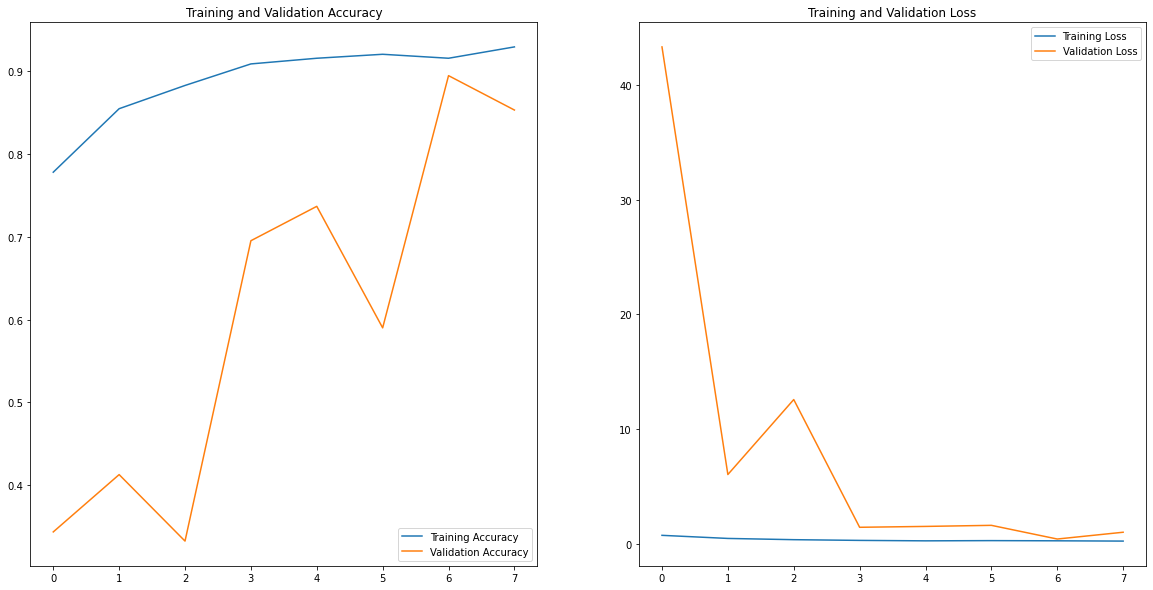

In [11]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
test_image_generator.reset()
prediction=model.predict_generator(test_image_generator,verbose=1)

submission.loc[:, 'healthy':] = prediction
submission.to_csv('submission.csv', index=False)

Instructions for updating:
Please use Model.predict, which supports generators.
1821/1821 [==============================] - 113s 62ms/step
